# Inference Demo

Ноутбук является примером инференса DEM CNN. В качестве данных выступает демо из пары изображение+аннотация, которые загружаются из Яндекс Диска через утилиту. Помимо самого инференса производится минималистичная постобработка результатов детекции для их лучшей интерпретации. Также берутся метрики: усредненная средняя точность (mean average precision, mAP) глобальная и с пересечением над объединением равным 0.50.

## Подготовка

Скачиваем необходимые для работы библиотеки. Импортируем их. Из конфига берем данные для демо и параметры загрузки модели.

In [1]:
%pip install torch torchvision torchmetrics mlflow pycocotools rasterio shapely

Note: you may need to restart the kernel to use updated packages.


In [2]:
import torch
from torchmetrics.detection import MeanAveragePrecision
from shapely.geometry import Polygon

from config import MLFLOW_URI, MLFLOW_MODEL, STATE_DICT, IMAGE_SIZE, DEMO_IMAGE, DEMO_ANNOTATION, SCORE_THRESHOLD, \
                   IOU_THRESHOLD, CLASSES_MAPPING, FPN, VARIANT, PRETRAINED, LAST_LEVEL_MAX_POOL, NORMALIZE
from utils import get_demo, plot

In [3]:
DEVICE = torch.device('cpu')  # speed does not matter as much for demo

## Загрузка модели

Есть 2 опции загрузки модели: через MLflow (как в evaluate.py) или через локально хранящийся файл. Первая опция полезна во время обучения, когда финальная версия модели ещё не была получена, но хочется визуально увидеть как она работает. Вторая опция предусмотрена для демонстрации того, как нужно встраивать DEM CNN в другие проекты, без доступа к MLflow. 

Чтобы выбрать опцию, раскомментируйте соотвествующий блок кода ниже.

In [4]:
import mlflow
from mlflow.utils import logging_utils

logging_utils.disable_logging()  # MLflow throws some excessive logging warnings

mlflow.set_tracking_uri(MLFLOW_URI)

model = mlflow.pytorch.load_model(MLFLOW_MODEL, map_location=DEVICE)

In [5]:
# if STATE_DICT:
#     from model import create_model
    
#     model = create_model(len(CLASSES_MAPPING), FPN, VARIANT, PRETRAINED, LAST_LEVEL_MAX_POOL, NORMALIZE)
#     model.load_state_dict(torch.load('weights/dem_cnn_sd.pt', weights_only=True))
# else:
#     model = torch.load('weights/dem_cnn.pt', weights_only=False)
# model = model.to(DEVICE)

## Вспомогательные функции

Удаление объектов из предсказания по их индексам. Постобработка предсказаний: фильтрация по уверенности, подавление немаксимумов.

In [6]:
def remove_by_indices(pred: dict, indices: list) -> dict:
    for i in sorted(indices, reverse=True):
        for k in pred.keys():
            pred[k] = torch.cat((pred[k][:i], pred[k][i+1:]))

    return pred

def postprocess_pred(pred: dict) -> dict:
    boxes, scores = pred['boxes'], pred['scores']
    
    shapes = []
    for box in boxes:
        x_min, y_min, x_max, y_max = box
        shapes.append(Polygon(((x_min, y_min), (x_min, y_max), (x_max, y_max), (x_max, y_min), (x_min, y_min))))

    indices = []  # to store indices of objects to remove
    approved = []  # to store shapes and scores of objects that passed non-maximum suppresion
    for i, (box, score, shape) in enumerate(zip(boxes, scores, shapes)):
        if score < SCORE_THRESHOLD:
            indices.append(i)
            continue

        for approved_shape, approved_score in approved:  # minimalistic non-maximum suppresion loop
            if approved_shape.intersects(shape) and approved_shape.intersection(shape).area / approved_shape.union(shape).area >= IOU_THRESHOLD and approved_score >= score:
                indices.append(i)
                continue
        approved.append((shape, score))

    return remove_by_indices(pred, indices)

## Инференс и взятие метрик

Делаем предсказание на основе демо (изображение+аннотация). Проводим постобработку результата. Берем метрики, сравнивая предсказание с истиной. Выводим предсказание.

In [7]:
map_metric = MeanAveragePrecision().to(DEVICE)

model.eval()
with torch.inference_mode():
    image, target = get_demo(DEMO_IMAGE, DEMO_ANNOTATION, IMAGE_SIZE)
    image_batched = image.unsqueeze(0)  # image is expected in a batch

    pred = model(image_batched)[0]
    pred = postprocess_pred(pred)

map_metric.update([pred], [target])

{
    'map': map_metric.compute()['map'],
    'map_50': map_metric.compute()['map_50']
}

{'map': tensor(0.6626), 'map_50': tensor(1.)}

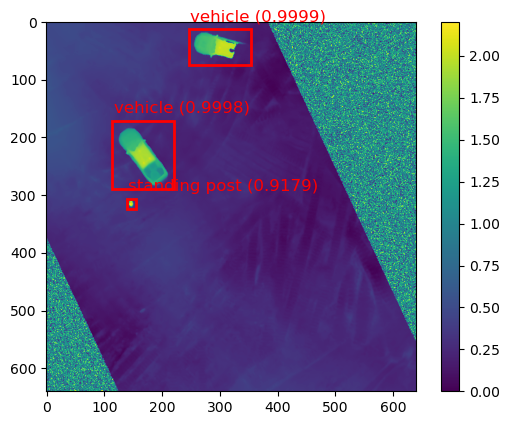

In [8]:
plot(image, pred, CLASSES_MAPPING)